# (1) Group Final Report - Group 20 - Calvin Du, Dishika Taneja, Geoff Lei, Stanley Yuan - Stat 301 - Dec. 5, 2025

# (2) Introduction

Total Body Water (TBW) is a physiological indicator that reflects how much water is contained in an individual's body. As such, TBW varies with characteristics such as tissue type and overall body size. For example, lean tissue (muscles and organs) contains approximately 70–75% water, whereas fat tissue carries only about 10% (Lorenzo et al., 2019). Basic anthropometric traits such as height, weight, BMI, and gender also relate to TBW because they reflect differences in body size and composition (Ritz et al., 2008).  

Using the variables available in this dataset, we aim to confirm well-established associations (such as those involving lean mass and body fat ratio), while also exploring the influence of variables that have been less frequently examined, such as gender.
Therefore our central research question is:  

**Which body composition and hydration-related variables are most strongly associated with total body water, and how do these selected predictors jointly explain variation in total body water?** 

To address this question, several multiple linear regression (MLR) models will be fit using totalbodywatertbw as the response variable and differing 
combinations of covariates as predictors. The primary goal is statistical inference about how these variables relate to TBW. In addition, LASSO regression will be used to identify which covariates contribute most effectively within this dataset.  

### Summary 

**Response variable:** `totalbodywatertbw`  

**Explanatory variables:** Explanatory variables: In Stage 2 of Calvin’s project, the variables used were leanmasslm, totalbodyfatratiotbfr, gender, height, weight, and bodymassindexbmi. In this report, we explore which variables are best using LASSO regression.

**Model type:** Multiple Linear Regression

**Focus:** Inference, to identify which body composition features contribute most to totalbodywatertbw

# (3) Method and Results

## 3a) Data

In [1]:
library(tidyverse)
library(broom)
library(glmnet)
library(dplyr)
library(readxl)
library(car)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
Loading required package: Matrix


Attaching package: ‘Matrix’


The following objects are masked from ‘package:tidyr’:

    expand, pack, unpack


Loaded glmnet 4.1-8

Loading required package: carData


Attaching package: ‘car’


The following object is masked from ‘package:dplyr’:

    recode


The following object is masked from ‘package:purrr’:

    some




In [2]:
set.seed(30120)

### Reproducible reading of dataset into R 

In [3]:
# Download ZIP 
outer_zip  <- tempfile(fileext = ".zip")
download.file("https://archive.ics.uci.edu/static/public/1150/gallstone-1.zip",
              outer_zip, mode = "wb")

# Unzip outer ZIP 
outer_dir <- tempfile()
unzip(outer_zip, exdir = outer_dir)

# Unzip inner ZIP 
inner_zip <- file.path(outer_dir, "dataset-uci.zip")
unzip(inner_zip, exdir = outer_dir)

# Read Excel file
excel_path <- file.path(outer_dir, "dataset-uci.xlsx")
df <- read_excel(excel_path)

# --- Preview ---
head(df)

cat("Column names:\n")
print(colnames(df))

cat("\nNumber of columns:\n")
print(length(colnames(df)))

cat("\nNumber of rows:\n")
print(nrow(df))


Gallstone Status,Age,Gender,Comorbidity,Coronary Artery Disease (CAD),Hypothyroidism,Hyperlipidemia,Diabetes Mellitus (DM),Height,Weight,⋯,High Density Lipoprotein (HDL),Triglyceride,Aspartat Aminotransferaz (AST),Alanin Aminotransferaz (ALT),Alkaline Phosphatase (ALP),Creatinine,Glomerular Filtration Rate (GFR),C-Reactive Protein (CRP),Hemoglobin (HGB),Vitamin D
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0,50,0,0,0,0,0,0,185,92.8,⋯,40,134,20,22,87,0.82,112.47,0,16.0,33.0
0,47,0,1,0,0,0,0,176,94.5,⋯,43,103,14,13,46,0.87,107.10,0,14.4,25.0
0,61,0,0,0,0,0,0,171,91.1,⋯,43,69,18,14,66,1.25,65.51,0,16.2,30.2
0,41,0,0,0,0,0,0,168,67.7,⋯,59,53,20,12,34,1.02,94.10,0,15.4,35.4
0,42,0,0,0,0,0,0,178,89.6,⋯,30,326,27,54,71,0.82,112.47,0,16.8,40.6
0,96,0,0,0,0,0,0,155,49.0,⋯,30,65,13,13,60,1.46,43.74,0,11.0,45.8


Column names:
 [1] "Gallstone Status"                              
 [2] "Age"                                           
 [3] "Gender"                                        
 [4] "Comorbidity"                                   
 [5] "Coronary Artery Disease (CAD)"                 
 [6] "Hypothyroidism"                                
 [7] "Hyperlipidemia"                                
 [8] "Diabetes Mellitus (DM)"                        
 [9] "Height"                                        
[10] "Weight"                                        
[11] "Body Mass Index (BMI)"                         
[12] "Total Body Water (TBW)"                        
[13] "Extracellular Water (ECW)"                     
[14] "Intracellular Water (ICW)"                     
[15] "Extracellular Fluid/Total Body Water (ECF/TBW)"
[16] "Total Body Fat Ratio (TBFR) (%)"               
[17] "Lean Mass (LM) (%)"                            
[18] "Body Protein Content (Protein) (%)"            
[19] "Visceral

### Dataset Summary

- **Dataset name:** Gallstone-1
- **Source:** [UCI Machine Learning Repository](https://archive.ics.uci.edu/dataset/1150/gallstone-1)
- **Number of observations:** 319
- **Number of variables:** 39


| Variable | Description | Type |
|-----------|--------------|------|
| xgallstonestatus | Presence of gallstones | Categorical|
| age | Age | Numeric|
| gender | Gender | Categorical |
| comorbidity | Presence of comorbid diseases | Categorical |
| coronaryarterydiseasecad | Coronary artery disease status | Categorical|
| hypothyroidism | Hypothyroidism status | Categorical|
| hyperlipidemia | Hyperlipidemia status | Categorical|
| diabetesmellitusdm | Diabetes mellitus status | Categorical|
| height, weight, bodymassindexbmi | Anthropometric measures | Numeric |
| totalbodywatertbw, extracellularwaterecw, intracellularwatericw, extracellularfluidtotalbodywaterecftbw | Body water and fluid distribution metrics | Numeric |
| totalbodyfatratiotbfr, leanmasslm, bodyproteincontentprotein, visceralfatratingvfr, bonemassbm, musclemassmm, obesity, totalfatcontenttfc, visceralfatareavfa, visceralmuscleareavmakg | Body composition metrics | Numeric |
| hepaticfataccumulationhfa | Liver fat accumulation indicator | Numeric |
| glucose, totalcholesteroltc, lowdensitylipoproteinldl, highdensitylipoproteinhdl, triglyceride | Blood biochemistry | Numeric |
| aspartataminotransferazast, alaninaminotransferazalt, alkalinephosphatasealp, creatinine, glomerularfiltrationrategfr, creactiveproteincrp, hemoglobinhgb, vitamind | Liver and kidney biomarkers | Numeric |


### Source and Information
- Data were collected prospectively and observationally from patients at Ankara VM Medical Park Hospital (June 2022 – June 2023).

- There were 454 participants but 134 individuals who had gallbladder surgery were omitted -> leading to 319 entries. Then 161 had gallstones and 158 were deemed healthy controls. (Esen et al., 2024).

- Each participant underwent clinical tests including bioimpedance analysis (BIA), blood laboratory tests, and ultrasound screening for gallstones in order to gather features

### Pre-selection of Variables
Some variables are highly correlated or redundant and may be removed. We grouped some of these variables above but here are some more concrete examples: 

- `height` and `weight` are represented by `bodymassindexbmi`

- `totalbodywatertbw`, `extracellularwaterecw`, and `intracellularwatericw` are collinear measures of hydration

- Some preliminary factors showed that variables under binary comorbidity indicators (`coronaryarterydiseasecad`, `diabetesmellitusdm`, etc.) can be summed into a single index as they represent similar underlying conditions. 


# 3b) Exploratory Data Analysis (EDA)

In [4]:
colnames(df) <- colnames(df) %>%
  tolower() %>%
  str_replace_all("\\s+", "_") %>%         
  str_replace_all("[^a-z0-9_]", "") %>%
  str_replace("^([0-9])", "x\\1")
colnames(df) <- str_replace_all(colnames(df), "_", "")

df$gender <- factor(df$gender,
                  levels = c(0, 1),
                  labels = c("Male", "Female"))


### EDA Plot 1: Exploring Muscle Mass vs Total Body Water by Gender

`geom_smooth()` using formula = 'y ~ x'


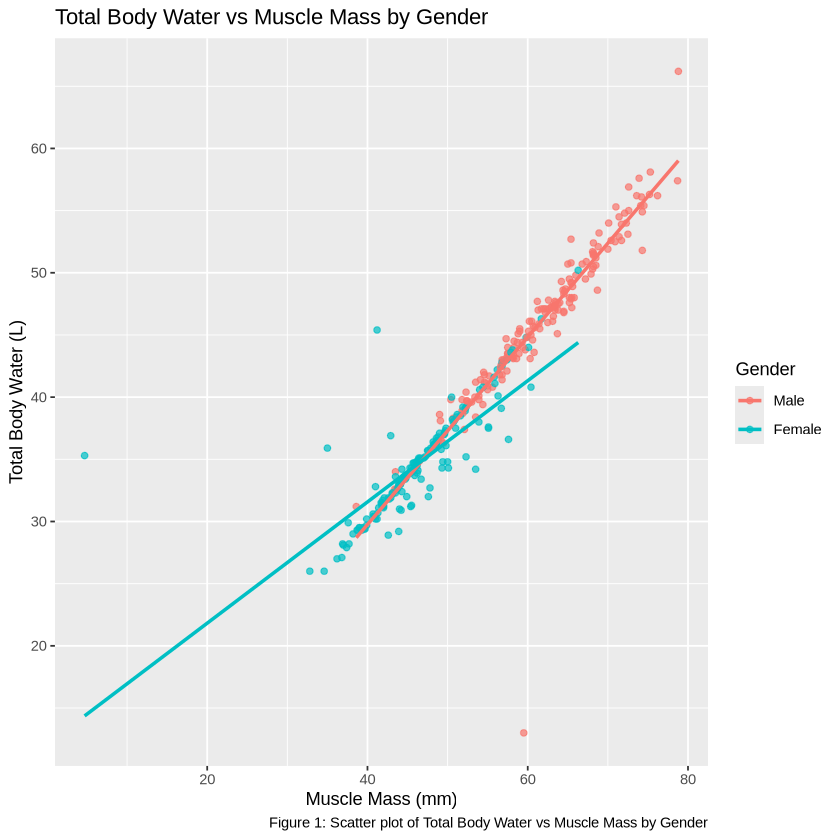

In [5]:
ggplot(df, aes(x = musclemassmm, y = totalbodywatertbw, color = gender)) +
  geom_point(alpha = 0.7) +
  geom_smooth(method = "lm", se = FALSE) +
  labs(
    title = "Total Body Water vs Muscle Mass by Gender",
    x = "Muscle Mass (mm)",
    y = "Total Body Water (L)",
    color = "Gender", 
    caption = "Figure 1: Scatter plot of Total Body Water vs Muscle Mass by Gender"
  ) 


**Relevancy:** 

This plot is relevant as it lets us explore how increasing muscle mass is associated with total body water. We also want to see how this relationship differs by gender.

**Results:**

We can see a positive association with muscle mass and TBW which makes sense as more muscle = more water. Additionally, we can see that males on average have a higher TBW and more muscle mass.

### EDA Plot 2: Exploring the Relationship Between Muscle Mass and Total Body Water with Visceral Muscle Area

`geom_smooth()` using formula = 'y ~ x'


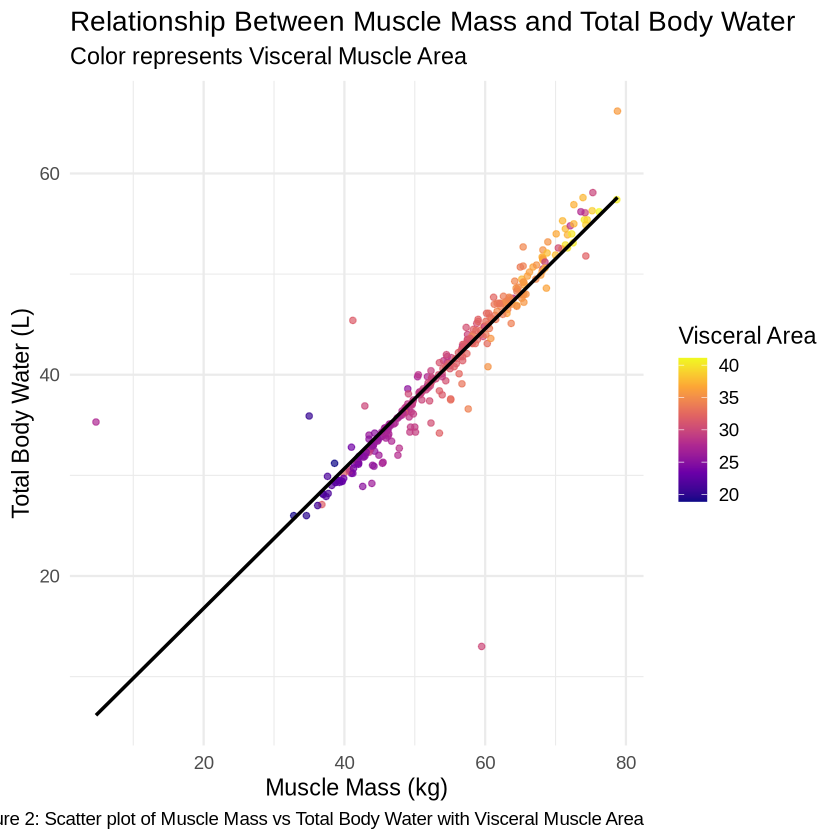

In [6]:
ggplot(df, aes(x = musclemassmm,
               y = totalbodywatertbw,
               color = visceralmuscleareavmakg)) +
  geom_point(alpha = 0.7) +
  geom_smooth(method = "lm", se = FALSE, color = "black") +
  scale_color_viridis_c(option = "plasma") +
  theme_minimal(base_size = 14) +
  labs(
    title = "Relationship Between Muscle Mass and Total Body Water",
    subtitle = "Color represents Visceral Muscle Area",
    x = "Muscle Mass (kg)",
    y = "Total Body Water (L)",
    color = "Visceral Area",
    caption = "Figure 2: Scatter plot of Muscle Mass vs Total Body Water with Visceral Muscle Area"
  )


**Relevancy:**   
We made this plot to explore the relationship between Muscle Mass, TBW and Visceral Muscle Area.   

**Results:**  
It appears that Muscle Mass and Visceral Muscle Area are positively correlated, which implies that there may be some collinearity between these variables. We can see that they both have positive associations with TBW, which coincides with the findings from the first EDA plot (more muscle mass = more water). HH\owever, in terms of inference, this may be a source of limitation. This is something to take note of, but the variables still provide useful information regarding their association with the response variable.

# 3c) Plan for Methods

The focus of our analysis is **inference**. We want to examine the association between an individual’s total body water (in L) and predictors related to gender and body proportional measurements. 

First, we will use **LASSO** regression for variable selection. This method performs automatic variable selection by shrinking the coefficients of less important features to exactly zero. It will narrow down which variables have the strongest ability to support inference about an individual’s total body water. This creates a more interpretable model that focuses only on the important predictors among the many variables present in the dataset. This also reduces overfitting, especially since we have a large number of potential variables.

- To perform LASSO regression, we will first define the response and the predictor matrix.
- To ensure reproducibility of the cross-validation splits, we will fix a random seed.
- We will then fit a LASSO model with K-fold cross-validation using cv.glmnet, which by default uses 10-fold-cross-validation. Hence, the data are split into 10 folds and for each candidate 𝜆, the model is trained on 9 folds and validated on the remaining fold.
- Using the value of 𝜆 that minimizes the cross-validated error, we will extract the estimated coefficients and will then identify the variables with non-zero coefficients to be used in the final model.

Then, we will fit an additive multiple linear regression model (with lm function) using **totalbodywatertbw** as the response variable and the variables selected by LASSO as the predictors. This will help us examine how the selected variables are associated with an individual’s total body water. 

This method is appropriate because the response variable is continuous, and the goal is to quantify how several body composition variables collectively explain variation in total body water.

**Assumptions for the method:** The assumptions of this method include linear relationships between factors and the response, independent observations, constant variance of residuals, and approximately normally distributed errors.

To check whether the linear regression assumptions will hold, we will make a plot of residuals vs fitted values and a normal QQ plot of the residuals. If the points in the residuals vs fitted values scatterplot are randomly scattered around zero showing no clear pattern, the assumption of linearity will be reasonable and there will be homoscedasticity. Furthermore, in the QQ plot, if the points will lie close to the reference line, it will suggest that the residuals are approximately normally distributed. These diagnostic plots will support the use of a multiple linear regression model for inference on the association between the selected predictors and total body water.

**Potential limitations of the proposed method:** Several predictors (height, weight, BMI, and lean mass) may be highly correlated here which can inflate standard errors and might make it hard to interpret the individual coefficients. Another limitation is that the model assumes linearity; however, physiological relationships may be nonlinear or involve interactions.


# 3d) Code

### Lasso Regression to Determine Model Fit

In order to determine the best variables to use in our model, we will proceed with utilizing lasso regression to narrow down which variables have the strongest inferential/explanatory ability.

In [7]:
y <- df$totalbodywatertbw
X <- model.matrix(totalbodywatertbw ~ ., data = df)[, -1, drop = FALSE]

set.seed(30120)
# get lasso model with cross-validation
lasso <- cv.glmnet(X, y, alpha = 1, standardize = TRUE)

lambda_min <- lasso$lambda.min

# Coefficients
coef_min <- coef(lasso, s = lambda_min)

selected_min <- setdiff(rownames(coef_min)[as.numeric(coef_min) != 0], "(Intercept)")

print(selected_min)

[1] "genderFemale"                          
[2] "extracellularwaterecw"                 
[3] "extracellularfluidtotalbodywaterecftbw"
[4] "musclemassmm"                          
[5] "visceralmuscleareavmakg"               


The model selected body composition variables that intuitively strongly associate with Total Body Water. Our final model will include sex (female with male as the baseline), extracellular water (ECW), the extracellular fluid ratio (ECF/TBW), muscle mass (MM), and visceral muscle area (VMA). 

All of these variables make sense, as water is primarily stored in muscle tissue. Therefore, predictors reflecting muscle quantity (MM, VMA) should strongly contribute. Hydration distribution (ECW, ECF/TBW) provides additional information regarding fluid balance and sex also remains important, as women naturally have lower TBW relative to men due to body-composition differences.

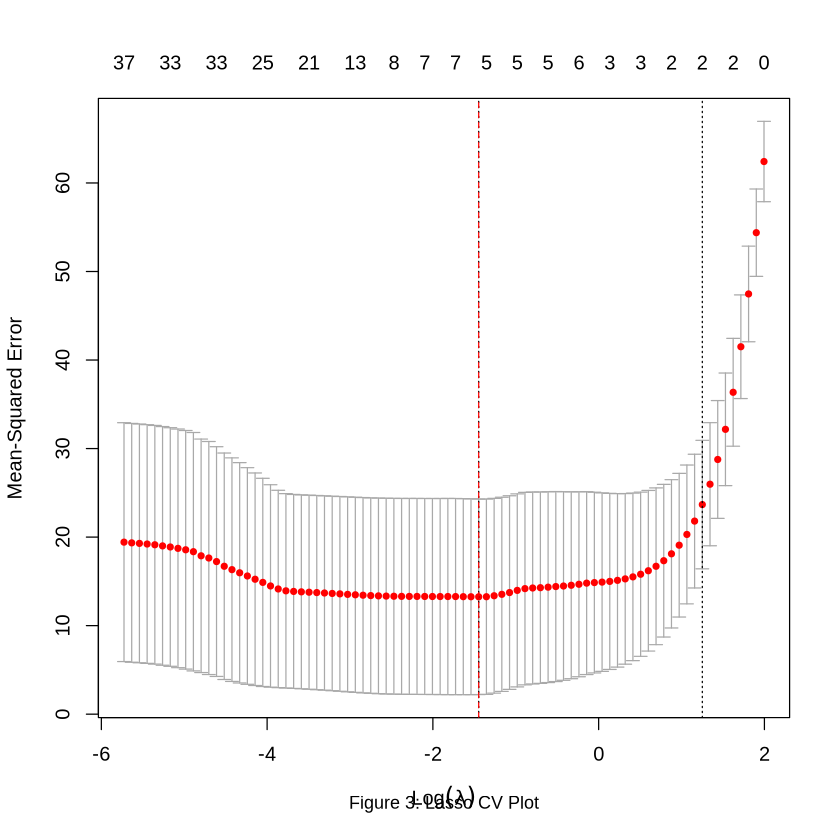

In [8]:
plot(lasso)
abline(v = log(lasso$lambda.min), col = "red", lty = 2)
title(sub = "Figure 3: Lasso CV Plot", cex.sub = 0.9, line = 3)

The CV LASSO curve shows that moderate regularization achieves the lowest prediction error. The optimal penalty parameter which is defined as $\lambda_{min}$ yields a model containing five physiologically meaningful predictors of Total Body Water.

In [9]:
# Model we will use: 
model <- lm(formula = totalbodywatertbw ~ gender + extracellularwaterecw + extracellularfluidtotalbodywaterecftbw + musclemassmm + visceralmuscleareavmakg, data = df)
summary(model) %>% tidy(conf.int = TRUE)

term,estimate,std.error,statistic,p.value,conf.low,conf.high
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),34.44094243,3.02747669,11.3761214,2.498116e-25,28.48416399,40.3977209
genderFemale,0.04683711,0.34824263,0.1344956,8.930971e-01,-0.63835535,0.7320296
extracellularwaterecw,2.33863118,0.13404327,17.4468373,4.323713e-48,2.07489138,2.6023710
extracellularfluidtotalbodywaterecftbw,-0.83414268,0.06791354,-12.2824211,1.439999e-28,-0.96776746,-0.7005179
musclemassmm,-0.00957481,0.03969965,-0.2411812,8.095726e-01,-0.08768672,0.0685371
visceralmuscleareavmakg,0.06351747,0.05155515,1.2320295,2.188628e-01,-0.03792101,0.1649559


### Interpretation of Model
At $\alpha = 0.05$, we can see that extracellularwaterecw and extracellularfluidtotalbodywaterecftbw have statistical significance in our model while the other variables have p-values that suggest less significance.

### Residual diagnostic plots

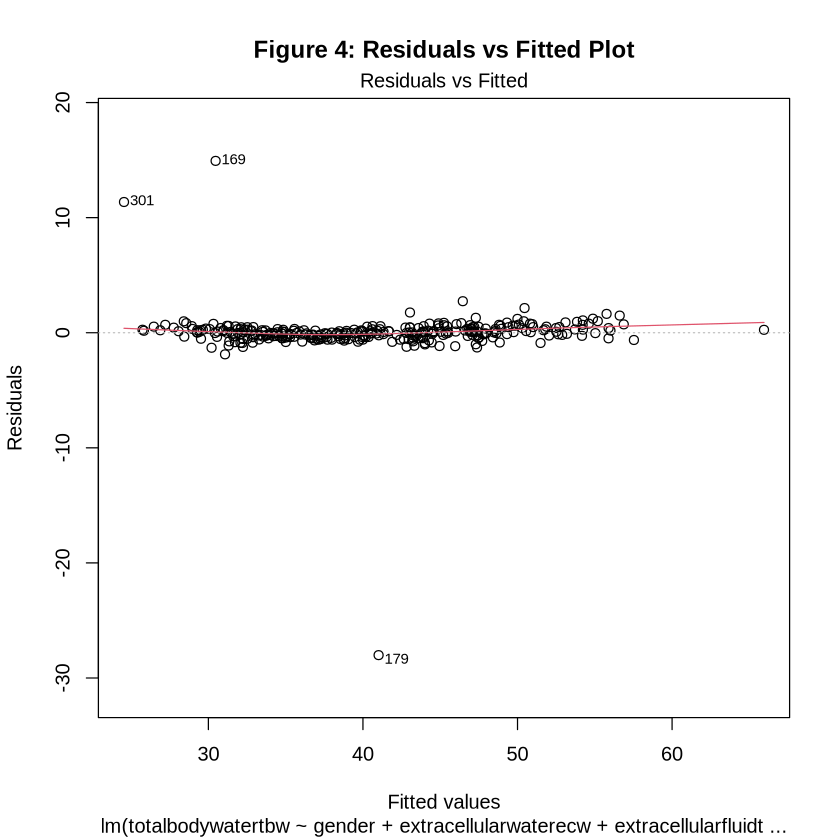

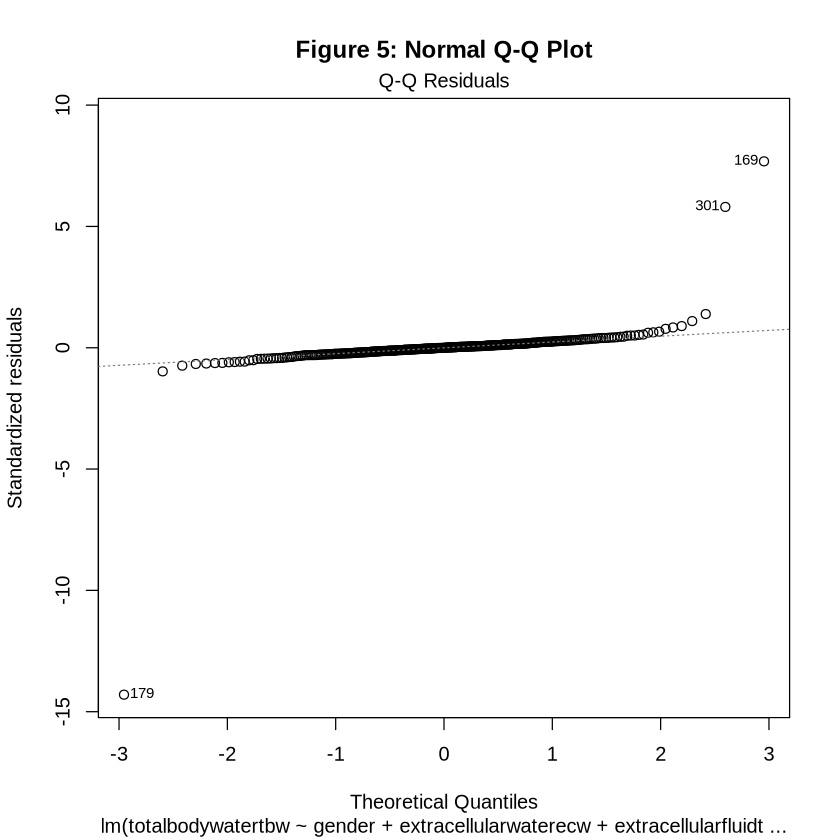

In [10]:
plot(model, which = 1, main = "Figure 4: Residuals vs Fitted Plot")
plot(model, which = 2, main = "Figure 5: Normal Q-Q Plot")

Looking at the diagnostic plots, our model satisfies the assumptions of linear regression. 

Residuals show no major heteroscedasticity or nonlinearity, and the QQ plot confirms approximate normality. These results support the validity of inference for the final model.

## 3d) Results

The variables selected using LASSO regression were:
- "genderFemale" (female with male as the baseline)
- "extracellularwaterecw" (extracellular water)
- "extracellularfluidtotalbodywaterecftbw" (the extracellular fluid ratio (ECF/TBW))
- "musclemassmm" (muscle mass (MM))
- "visceralmuscleareavmakg" (visceral muscle area (VMA))

Residual vs fitted values plot and normal QQ plots did not show severe violations of linearity, constant variance or normality. Hence, using the variables selected by LASSO, we fitted an additive multiple linear regression model. Based on the p-values from this model, only ECW and the ECF/TBW ratio were statistically significant at the 5% level, while gender, muscle mass, and VMA were not. These non-significant variables were retained as adjustment covariates to control for differences in body composition when estimating the effects of ECW and ECF/TBW on total body water.

$totalbodywatertbw_i = \hat{\beta_0}  + \hat{\beta_1} genderFemale_i+ \hat{\beta_2} extracellularwaterecw_i+ \hat{\beta_3} extracellularfluidtotalbodywaterecftbw + \hat{\beta_4} musclemassmm + \hat{\beta_5}visceralmuscleareavmakg $


After fitting we found the following values,\
$\mathbf{R^2}$ = 0.9383\
**Adjusted $\mathbf{R^2}$** = 0.9374\
This means that about 94% of the variability in total body water is explained by the selected predictors. This indicates strong inferential/explanatory power.

**Interpretation of coefficients:**
- $\hat{\beta_0} = 34.44$ **(*)** is the intercept, which is the estimated mean total body water for a male when all other continuous predictors are 0.
- $\hat{\beta_1} = 0.05$ **(NS)** is the coefficient for genderFemale. Keeping all other predictors constant, females are estimated to have about 0.05L higher total body water than males.
- $\hat{\beta_2} = 2.34$ **(*)** is the coefficient for extracellularwaterecw. Keeping all other predictors constant, a 1L increase in extracellular water is associated with an increase in estimated total body water on average by about 2.34L.
- $\hat{\beta_3} = -0.83$ **(*)** is the coefficient for extracellularfluidtotalbodywaterecftbw. Keeping all other predictors constant, a 0.1 increase in the extracellular fluid ratio is associated with a 0.83L decrease in the estimated total body water.
- $\hat{\beta_4} = -0.0095$ **(NS)** is the coefficient for musclemassmm. Keeping all other predictors constant, a 1 unit increase in the muscle mass is associated with a 0.0095L decrease in the estimated total body water. The estimated coefficient is very small and hence does not appear to have a noticeable impact on total body water.
- $\hat{\beta_5} = 0.063$ **(NS)** is the coefficient for visceralmuscleareavmakg. Keeping all other predictors constant, a 1 unit increase in the visceral muscle area is associated with a 0.063L increase in the estimated total body water. The value is again very small and hence does not appear to have a noticeable impact on total body water.

**Hypothesis tests of interest:**\
$H_0 : \beta_j = 0$ vs $H_1 : \beta_j \ne 0$, for each predictor


**Based on p-values,** at a 5% significance level, we can say that the only statistically significant predictors are extracellularwaterecw (ECW) and extracellularfluidtotalbodywaterecftbw (ECF/TBW ratio) because their p-value < 0.05. Gender, muscle mass and VMA are not statistically significant predictors because their p-values > 0.05.


**Comparison to other models:**
Compared with a full model that includes all predictors, the LASSO selected model is simpler and more interpretable. It is also statistically efficient since less important variables have been removed, which helps prevent overfitting. This model also helps us focus on inference, allowing us to state clearly that ECW and ECF/TBW ratio are the most important features associated with total body water. 

Therefore, these results answer our scientific question of understanding the association between an individual's total body water and other predictors. Also, they help us identify which body composition features contribute the most to total body water. We can say that extracellular water(ECW) and ECF/TBW ratio are the features that contribute the most to total body water.

# (4) Discussion

### Summary of the findings and their implications  

Our analysis identified extracellular water (ECW) and the extracellular fluid ratio (ECF/TBW) as statistically significant predictors of total body water (TBW). Although LASSO initially selected other additional variables (gender, muscle mass, and visceral muscle area), they did not remain significant in the multiple linear regression model. This indicates that once hydration-specific variables are included, the contribution of muscle mass or gender differences become non-significant. The final model explained approximately 94% of the variability in TBW which shows strong explanatory power under an inferential framework. It shows that fluid-distribution metrics are the strongest indicators of TBW in this dataset.  

### Potential improvements to the model  

There are parts to this model that could be potentially improved. There are predictors in the dataset such as height, weight, BMI, and lean mass which are correlated to an extent. This overlap of related predictors can inflate all of their impact to the model which can cause increased standard errors. This can be mitigated through improved pre-processing, such as removing or combining highly correlated predictors or applying dimension-reduction techniques like principal component analysis. Also, the model assumes linearity, but physiological relationships such as ones between muscle tissue and water content may be nonlinear. This could be addressed by including nonlinear terms in the model or by using generalized additive models, which allow for flexible nonlinear relationships.  

The dataset also includes clinical predictors whose relationships with TBW may differ across subgroups defined by gender, age, or health conditions. This could be addressed by conducting stratified analyses or by including interaction terms to better capture how TBW varies across these factors.  

#### Further research this study can lead to  

A possible direction of further research from this study is to investigate whether the inferential findings regarding ECW and the ECF/TBW ratio remain consistent across different populations, such as athletes, older adults, or individuals with conditions that affect fluid retention. Other related research could also analyze how TBW changes over time in response to factors such as hydration, exercise, diet, or medical treatment.

Another possible direction of further research could involve using different modelling methods to analyze variables and relationships that might not be linear or may not be well captured by LASSO. Other sampling methods could also be explored in future studies, such as using bootstrapping or other resampling methods to test the stability of predictors across different population samples.

# (5) References

1. Lorenzo I, Santos DA, Cunha G, Nunez-Felipe L, Figueiredo P, Silva AM, et al. The role of water homeostasis in muscle function and frailty. Nutrients. 2019;11(3):E552. 

2. Ritz P, Vol S, Berrut G, Tack I, Arnaud MJ, Tichet J, et al. Influence of gender and body composition on hydration and body water spaces. Clin Nutr. 2008 Oct;27(5):740–746.  